<a href="https://colab.research.google.com/github/Manar-Hamed/Arabic_Sign_Language/blob/main/Image_Text_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Mounting Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# Unziping the Images file
# !unzip data\ArASL_Database_54K_Final.zip -d data
# !tar -xf data\ArASL_Database_54K_Final.zip

In [ ]:
# !pip install gTTS
# !pip install playsound==1.2.2

#### Importing Libraries

In [1]:
# Importing required libraries

from keras.metrics import Precision, Recall, Accuracy
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from playsound import playsound
from tensorflow import keras
import tensorflow as tf
from gtts import gTTS
import numpy as np
import pandas as pd
import shutil
import cv2
import os


##### Checking Image Size

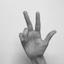

In [5]:
# Visualizing an Image
img = tf.keras.preprocessing.image.load_img(r'data\ArASL_Database_54K_Final\ArASL_Database_54K_Final\al\AL (1).JPG')
img

In [6]:
cv2.imread(r'data\ArASL_Database_54K_Final\ArASL_Database_54K_Final\al\AL (1).JPG').shape

(64, 64, 3)

In [7]:
img.size


(64, 64)

### Loading Images

In [4]:
# Loading images
data = tf.keras.utils.image_dataset_from_directory('data\ArASL_Database_54K_Final\ArASL_Database_54K_Final')

Found 54049 files belonging to 32 classes.


In [5]:
data_iterator = data.as_numpy_iterator()

In [6]:
batch = data_iterator.next()

In [7]:
batch[0].shape

(32, 256, 256, 3)

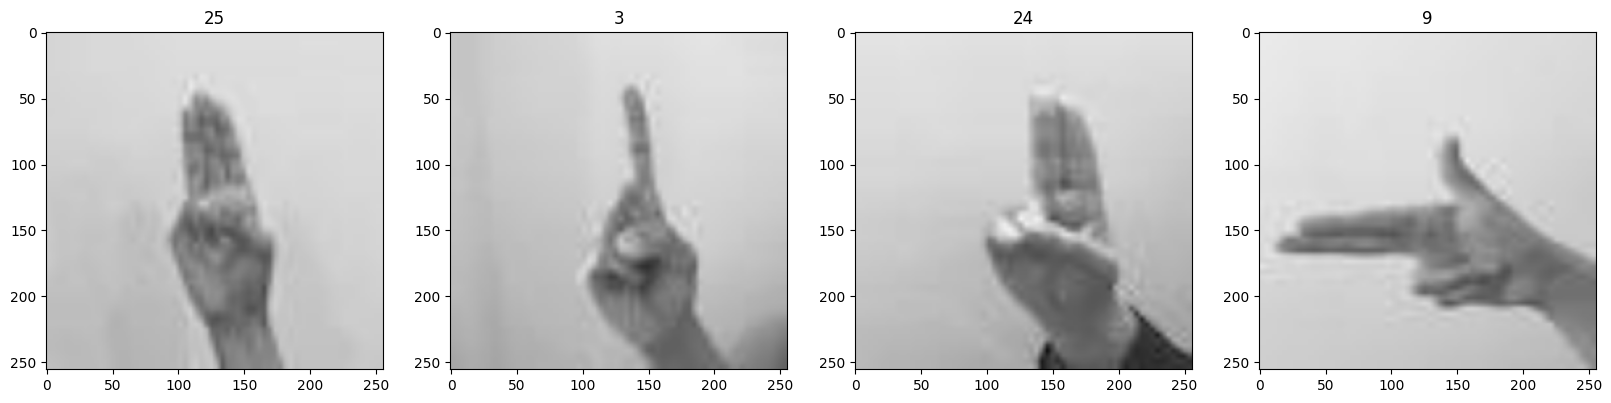

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

### Scaling Data

In [9]:
# Scale Data
data = data.map(lambda x,y: (x/255, y))

In [10]:
scaled_itertor = data.as_numpy_iterator()

In [11]:
batch = scaled_itertor.next()

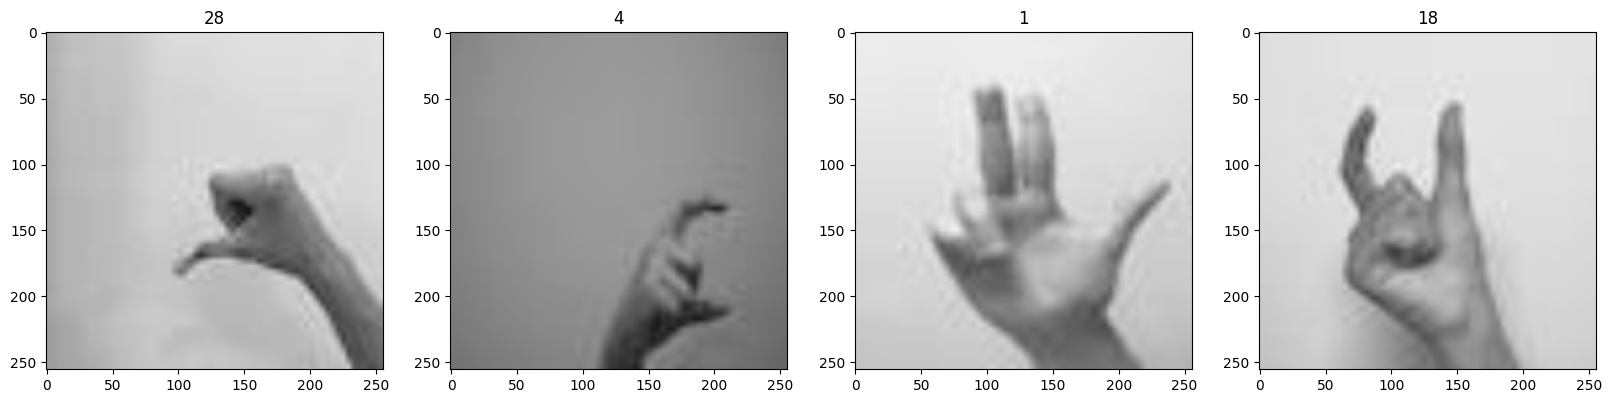

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

### Splitting Data

In [13]:
train_size = int(len(data) * 0.7)
test_size = int(len(data) * 0.2)
valid_size = int(len(data) * 0.1)

In [14]:
train =  data.take(train_size)
test = data.skip(train_size).take(test_size)
valid = data.skip(train_size+test_size).take(valid_size)

In [15]:
len(train)

1183

### Creating the CNN Model

In [20]:
# Defining the CNN

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(32, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

In [22]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
save_best_cb = keras.callbacks.ModelCheckpoint('models/best_model', save_best_only=True) # Saves the best model so far
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5) # Interupts training when there is no progress

#### Training

In [24]:
history = model.fit(train, epochs=20, validation_data=test, callbacks=[save_best_cb, early_stopping_cb])

Epoch 1/20
1183/1183 [==============================] - ETA: 0s - loss: 1.3568 - accuracy: 0.6276

INFO:tensorflow:Assets written to: models\best_model\assets


INFO:tensorflow:Assets written to: models\best_model\assets


1183/1183 [==============================] - 742s 627ms/step - loss: 1.3568 - accuracy: 0.6276 - val_loss: 0.4189 - val_accuracy: 0.8931
Epoch 2/20
1183/1183 [==============================] - ETA: 0s - loss: 0.2514 - accuracy: 0.9336

INFO:tensorflow:Assets written to: models\best_model\assets


INFO:tensorflow:Assets written to: models\best_model\assets


1183/1183 [==============================] - 695s 587ms/step - loss: 0.2514 - accuracy: 0.9336 - val_loss: 0.3475 - val_accuracy: 0.9129
Epoch 3/20
1183/1183 [==============================] - 738s 623ms/step - loss: 0.1175 - accuracy: 0.9672 - val_loss: 0.3704 - val_accuracy: 0.9247
Epoch 4/20
1183/1183 [==============================] - 671s 567ms/step - loss: 0.0664 - accuracy: 0.9808 - val_loss: 0.4645 - val_accuracy: 0.9214
Epoch 5/20
1183/1183 [==============================] - 684s 578ms/step - loss: 0.0548 - accuracy: 0.9857 - val_loss: 0.4049 - val_accuracy: 0.9323
Epoch 6/20
1183/1183 [==============================] - 667s 563ms/step - loss: 0.0350 - accuracy: 0.9914 - val_loss: 0.3943 - val_accuracy: 0.9391
Epoch 7/20
1183/1183 [==============================] - 672s 568ms/step - loss: 0.0287 - accuracy: 0.9924 - val_loss: 0.3922 - val_accuracy: 0.9340


In [25]:
history.history # Contains the training related information for each epoch

{'loss': [1.356799602508545,
  0.25137820839881897,
  0.1174679845571518,
  0.06636571884155273,
  0.054794345051050186,
  0.03498949110507965,
  0.02866065502166748],
 'accuracy': [0.6276151537895203,
  0.9336432814598083,
  0.9672442674636841,
  0.980848491191864,
  0.9856561422348022,
  0.9913619756698608,
  0.992418646812439],
 'val_loss': [0.41893401741981506,
  0.3475398123264313,
  0.3704197108745575,
  0.4644622802734375,
  0.40485575795173645,
  0.39429962635040283,
  0.3922460079193115],
 'val_accuracy': [0.8931213021278381,
  0.91290682554245,
  0.9247411489486694,
  0.9214127063751221,
  0.9323225021362305,
  0.939071774482727,
  0.9339866638183594]}

#### Performance Plotting

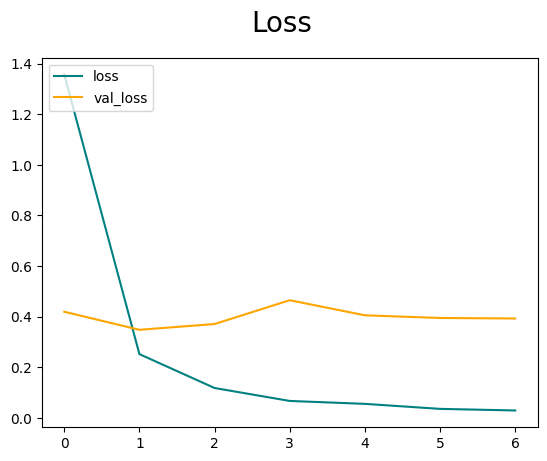

In [26]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

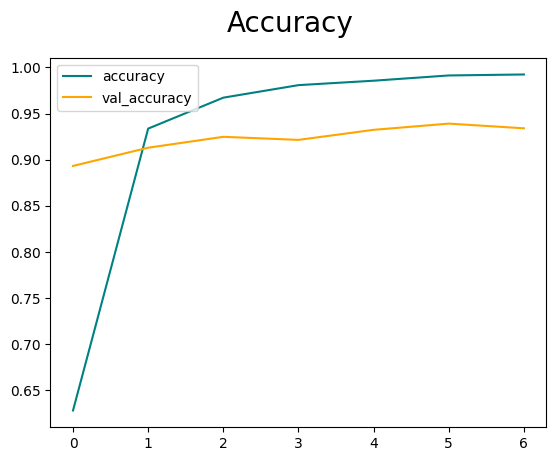

In [27]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate Performance

In [28]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [29]:
for batch in valid.as_numpy_iterator():
  x, y = batch
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 301ms/step


ValueError: Shapes (32, 32) and (32,) are incompatible

In [ ]:
print(f'Precision: {pre.result().nupmy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

### Save Model

In [16]:
# Loading Best Saved Model
# ArSL_model = load_model('models/best_model')

In [62]:
# Saving the model
model.save('models/ArSLText.h5')

In [2]:
# Loading the Model
ArSL_model = load_model('models/ArSLText.h5')

### Testing

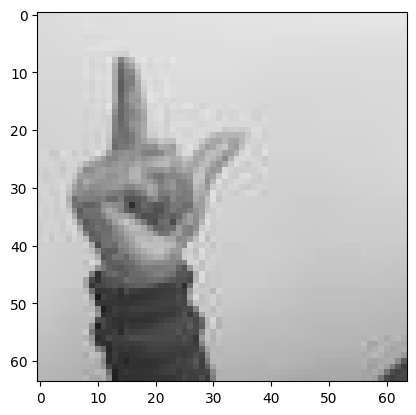

In [19]:
img = cv2.imread('data\Test\LAAM (10).JPG')
plt.imshow(img)
plt.show()

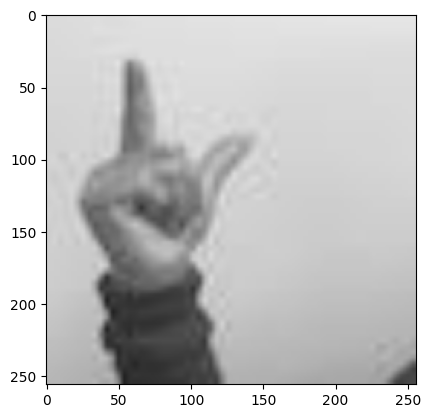

In [20]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [21]:
np.expand_dims(resize, 0)

array([[[[219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         ...,
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ]],

        [[219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         ...,
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ],
         [230.      , 230.      , 230.      ]],

        [[219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         [219.      , 219.      , 219.      ],
         ...,
         [229.875   , 229.875   , 229.875   ],
         [229.875   , 229.875   , 229.875   ],
         [229.875   , 229.875   , 229.875   ]],

        ...,

        [[183.125   , 183.125   , 183.125   ],
         [183.125   , 183.125   , 183.125   ]

In [30]:
yhat = ArSL_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 76ms/step


In [31]:
yhat

array([[1.9767562e-08, 6.6725491e-04, 1.1522738e-07, 6.2364568e-05,
        2.0283363e-08, 1.0548746e-01, 7.9624612e-10, 2.4255771e-05,
        5.6554541e-07, 4.5890229e-06, 9.2435997e-09, 3.7553138e-05,
        8.7841824e-11, 2.8912270e-09, 8.1495875e-07, 3.8119889e-09,
        7.4495476e-01, 3.0380487e-04, 2.5433907e-04, 4.9009013e-06,
        1.0246659e-05, 5.2517977e-09, 5.7949312e-04, 2.1816001e-04,
        1.6534002e-02, 3.1558005e-04, 8.1899735e-08, 6.5266031e-06,
        1.3033175e-01, 9.5168498e-06, 6.1300978e-09, 1.9188819e-04]],
      dtype=float32)

In [32]:
maxValue = np.amax(yhat[0])
maxValue

0.74495476

In [33]:
result = np.where(yhat[0] == np.amax(yhat[0]))
phon_num = result[0][0]

### Converting Images to Text

##### Making Arabic Letters Guide

In [ ]:
# encoded_labels = pd.DataFrame()

In [ ]:
#Classes Dictionary
# label = pd.read_csv('data\ArSL_Data_Labels.csv')

In [ ]:
# label.head(3)

,#,File_Name,Class
0,1,AIN (1).JPG,ain
1,2,AIN (10).JPG,ain
2,3,AIN (100).jpg,ain


In [ ]:
# encoded_labels['Phonteics'] = label['Class'].unique()

In [ ]:
# numbers  = [i for i in range(32)]

In [ ]:
# encoded_labels['Index'] = numbers

In [ ]:
# arab_list = list()

In [ ]:
# for eng_lab in  label['Class'].unique():
#   print('English Label: ', eng_lab)
#   arab_lab = input('Arabic Label: ')
#   arab_list.append(arab_lab)

In [ ]:
# encoded_labels['Arabic_Letters'] = arab_list

In [ ]:
# encoded_labels.head(3)

,Phonteics,Index,ِArabic_Letters
0,ain,0,ع
1,al,1,ال
2,aleff,2,أ


In [ ]:
# encoded_labels.to_csv('data/Arabic_Letters_Guide.csv', index=False)

#### Letters Extraction

In [16]:
encoded_labels = pd.read_csv('data/Arabic_Letters_Guide.csv')
# encoded_labels.head(3)

In [45]:
# This shows that the model predicted the image correctly
letter = encoded_labels[encoded_labels['Index'] == phon_num]
arab_letter = letter['Arabic_Letters']
arab_letter.iloc[0]

'ل'

In [24]:
# test_pics = data.random()
test_dir = 'data\Test'
images_list = []
Text = ''

for images in os.listdir(test_dir):
    if (images.endswith(".jpg") or images.endswith(".jpeg") or images.endswith(".JPG") or images.endswith(".JPEG")):
        print(images)
        imPath = test_dir + "\\" + images
        # print(imPath)
        image = cv2.imread(imPath)
        images_list.append(image)
        # plt.imshow(image)
        # plt.show()
        # cv2.imshow(images)

1 - LAAM (10).JPG
2 - GHAIN (1002).JPG
3 - TOOT (102).jpg
4 - AL (6).JPG
5 - MEEM (3).JPG
6 - Nun (3).JPG
7 - Aleff (6).JPG
8 - RA (4).JPG


In [25]:
for x in images_list:
    # print(x)
    # plt.imshow(x)
    # plt.show()
    resize = tf.image.resize(x, (256,256))

    np.expand_dims(resize, 0)

    yhat = ArSL_model.predict(np.expand_dims(resize/255, 0))

    maxValue = np.amax(yhat[0])

    result = np.where(yhat[0] == np.amax(yhat[0]))
    phon_num = result[0][0]

    letter = encoded_labels[encoded_labels['Index'] == phon_num]
    arab_letter = letter['Arabic_Letters'].iloc[0]
    Text = Text + arab_letter

1/1 [==============================] - 0s 42ms/step


In [26]:
Text


'لغةالمنار'

### Text to Speech

In [27]:
txt_sound = gTTS(text=Text, lang='ar', slow=False)

aud_name = 'audio/ArSL_Audio_' + Text + '.mp3'
txt_sound.save(aud_name)

In [23]:
# os.system('audio/ArSL_Audio.mp3')
playsound(aud_name)

PlaysoundException: 
    Error 275 for command:
        open "audio/ArSL_Audio_منار.mp3" alias playsound_0.8969741453338944
    Cannot find the specified file.  Make sure the path and filename are correct.